# Predicting Repository Languages an NLP Project
#### By Heather McMillan
#### Desiree McElroy
#### Carl Griffin



In [1]:
import pandas as pd
import numpy as np
import unicodedata
import re
import nltk

# imports for visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm # for colormap tools
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

# import modules 
import prepare as p
import acquire as a
import explore as ex
import model as m

# imports for NLP extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('seaborn-darkgrid')
sns.set_palette('viridis')

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Overview and Goals
The goal of this project is to determine the main coding language of a project based on the contents of it's github Readme, using NLP methods. The data was acquired from various repositories on Github. In order to recreate this project you will need to access the json of the data we acquired. During the acquisition of the repo names, we filtered for the word customer, not for any particular reason other than something to filter for. 

A total of 193 Repos were obtained but after dropping nulls, readmes with Chinese characters, and slimming it down to the top most prevalent languages in our dataset we ended up with data from 106 different documents. The 4 languages that we filtered for were, Java, JavaScript, PHP, and Jupyter Notebook. 

## Findings
We found that an SVC model using Lemmatized data, and  performed the highest with an accuracy of 81% on the validate data set (unseen). With a final test accuracy of 82%. This outperformed our baseline accuracy of 38%. Our model was very effective at predicting the PHP and Jupyter Notebook readmes accurately, but had a harder time correctly guessing Java and JavaScript. 

### With More Time
We'd like to acquire more data to see if we can improve the results for distinguishing Java and Java Script. We didn't have a lot of samples to work with. We'd also like to 

In [2]:
# read in data from Json
df = pd.read_json('data2.json')

# take a peak at it
df.head()

repo    language  \
0         codingXiaxw/CustomerManagement        Java   
1              DanWahlin/CustomerManager  JavaScript   
2          Tophold/FinancialCustomerView        Java   
3      DanWahlin/CustomerManagerStandard  JavaScript   
4  spring-cloud-samples/customers-stores        Java   

                                     readme_contents  
0  ## JavaWeb项目之客户管理系统 \n\n## 项目介绍\n详细讲解请点击这里前往我的...  
1  Customer Manager with AngularJS (with custom r...  
2  ## FinancialCustomerView\n* 本项目会对金融交易软件中存在的各种V...  
3  Customer Manager with AngularJS\r\n===========...  
4  # REST based micro-services sample\n\n- Three ...

It looks like we have some Chinese in here. Let's take a look at the different coding languages we have.

In [3]:
df.language.value_counts(dropna = False)

PHP                 41
Jupyter Notebook    32
JavaScript          25
Java                23
Python              20
C#                  12
NaN                  7
HTML                 4
TypeScript           4
R                    4
Vue                  3
Ruby                 3
Go                   3
HCL                  2
Dart                 2
PowerShell           2
CSS                  2
Shell                1
Scala                1
ABAP                 1
Objective-C          1
Swift                1
Name: language, dtype: int64

Since we have so many different types of languages here let's take the top 4 and filter for those. Maybe in a later model we can come back and create models for some other languages.

In [4]:
# we're going to drop chinese rows, unused languages, and any empty languages if we have any
df = p.drop_unneeded_data(df)

# we'll also prepare the data for NLP processing dropping a few words 
# that were present in almost all the readmes
df = p.prepare_nlp_data(df, content = 'readme_contents', extra_words=['customer', 'customers', '1', '2'])

In [5]:
# take a look at what we have remaining
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             106 non-null    object
 1   language         106 non-null    object
 2   readme_contents  106 non-null    object
 3   clean            106 non-null    object
 4   stemmed          106 non-null    object
 5   lemmatized       106 non-null    object
dtypes: object(6)
memory usage: 5.1+ KB


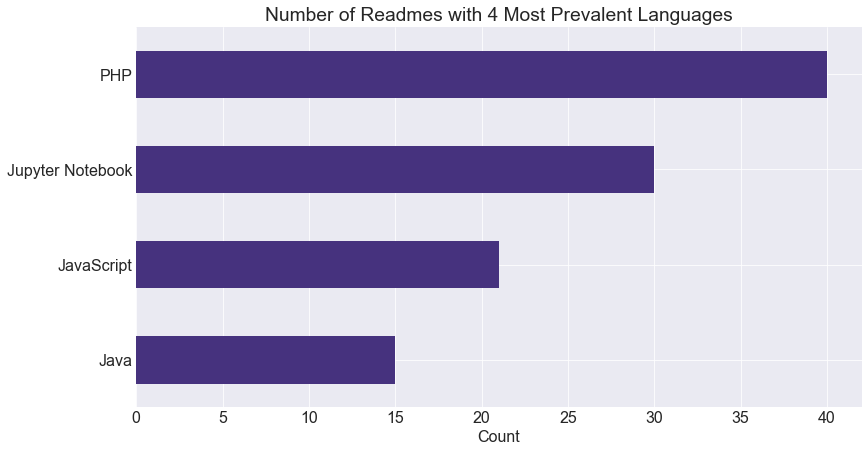

In [6]:
df.language.value_counts().sort_values(ascending = True).plot.barh()
plt.title('Number of Readmes with 4 Most Prevalent Languages')
plt.xlabel("Count")
plt.show()

In [7]:
# data is now cleaned lemmatized and stemmed for us to explore with
df.head()

repo          language  \
0                          DanWahlin/CustomerManager        JavaScript   
1                  DanWahlin/CustomerManagerStandard        JavaScript   
2              spring-cloud-samples/customers-stores              Java   
3  eventuate-tram/eventuate-tram-examples-custome...              Java   
4                Featuretools/predict-customer-churn  Jupyter Notebook   

                                     readme_contents  \
0  Customer Manager with AngularJS (with custom r...   
1  Customer Manager with AngularJS\r\n===========...   
2  # REST based micro-services sample\n\n- Three ...   
3  # Eventuate Tram Customers and Orders\n\nThis ...   
4  # A Machine Learning Framework with an Applica...   

                                               clean  \
0  manager angularjs custom routing dynamic contr...   
1  manager angularjs youre new angularjs check an...   
2  rest based microservices sample three spring b...   
3  eventuate tram orders application demonstrates...   
4  machine learning framework application predict...   

                                             stemmed  \
0  manag angularj custom rout dynam control scrip...   
1  manag angularj your new angularj check angular...   
2  rest base microservic sampl three spring boot ...   
3  eventu tram order applic demonstr two key patt...   
4  machin learn framework applic predict churn im...   

                                          lemmatized  
0  manager angularjs custom routing dynamic contr...  
1  manager angularjs youre new angularjs check an...  
2  rest based microservices sample three spring b...  
3  eventuate tram order application demonstrates ...  
4  machine learning framework application predict...

## Exploration
In this section we find that bigrams and trigrams across the different languages are fairly different while there are very few words that are 100% specific to one language or another. With a few exceptions being 'magento' found only in jupyter notebooks, and funnily the word 'notebook' is only in PHP. The word 'model' is found in PHP readmes 95% of the time. And the word 'extension' is mostly in Jupyter Notebooks but only found elsewhere in Java readmes.

We also decided to add the words customer, customers, 1, and 2 to the stopwords. They were removed in the prepare function.

In [8]:
# split in to train validate and test groups
train, validate, test = p.split_data(df)

train---> (58, 6)
validate---> (26, 6)
test---> (22, 6)


In order to see the percentages of all the words we first have to obtain counts of all the words in the text in order to visualize. We joined all the text from the readmes of the same language together, split it up into words, then did a value counts.

In [9]:
all_word_counts = ex.get_word_counts_series(train, 'lemmatized')
javascript_word_counts = ex.get_word_counts_series(train[train.language == 'JavaScript'], 'lemmatized')
java_word_counts = ex.get_word_counts_series(train[train.language == 'Java'], 'lemmatized')
jupyter_word_counts = ex.get_word_counts_series(train[train.language == 'Jupyter Notebook'], 'lemmatized')
php_word_counts = ex.get_word_counts_series(train[train.language == 'PHP'], 'lemmatized')

In [10]:
# create list of all the previous counts
word_counts_list = [javascript_word_counts,java_word_counts, jupyter_word_counts, php_word_counts,  all_word_counts]

# create list of names for columns
column_names = list(df.language.unique())
column_names.append('all')

# create list of languages
languages = list(df.language.unique())

In [11]:
languages

['JavaScript', 'Java', 'Jupyter Notebook', 'PHP']

In [12]:
# create dataframe of the counts for graphing later
word_counts = pd.concat(word_counts_list, axis=1).fillna(0).astype(int)
word_counts.columns = column_names
word_counts.head()

JavaScript  Java  Jupyter Notebook  PHP  all
new                  45     7                22   24   98
install              26     4                 5   23   58
feature              23     1                77   30  131
using                23    47                55   25  150
application          23    36                13    3   75

<Figure size 1152x648 with 0 Axes>

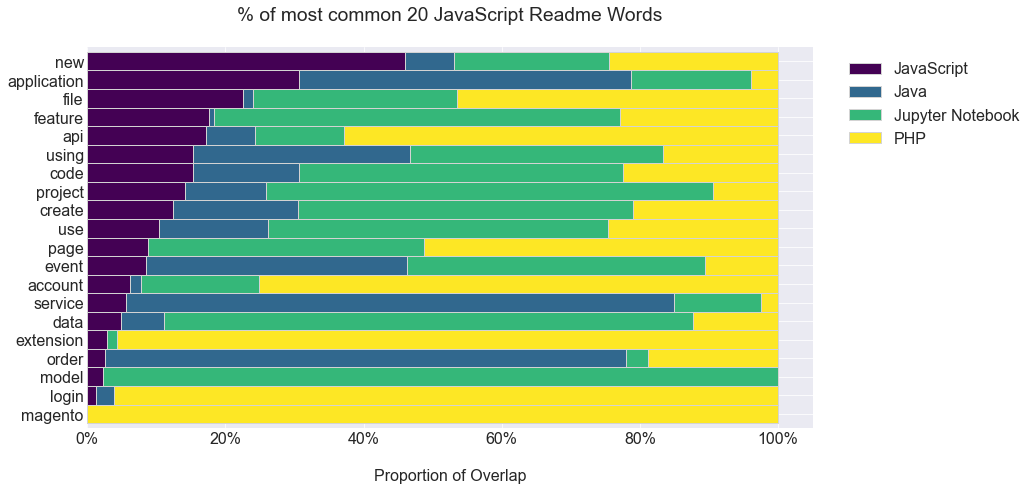

<Figure size 1152x648 with 0 Axes>

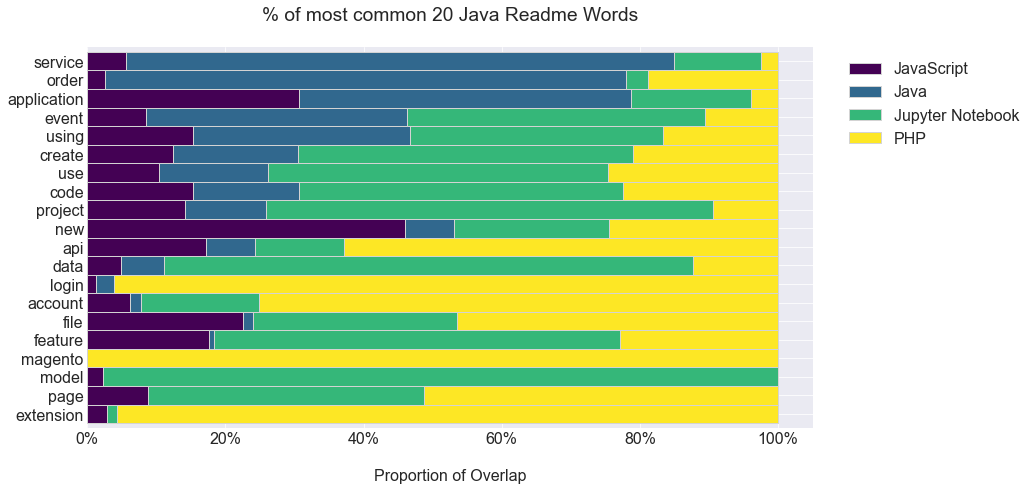

<Figure size 1152x648 with 0 Axes>

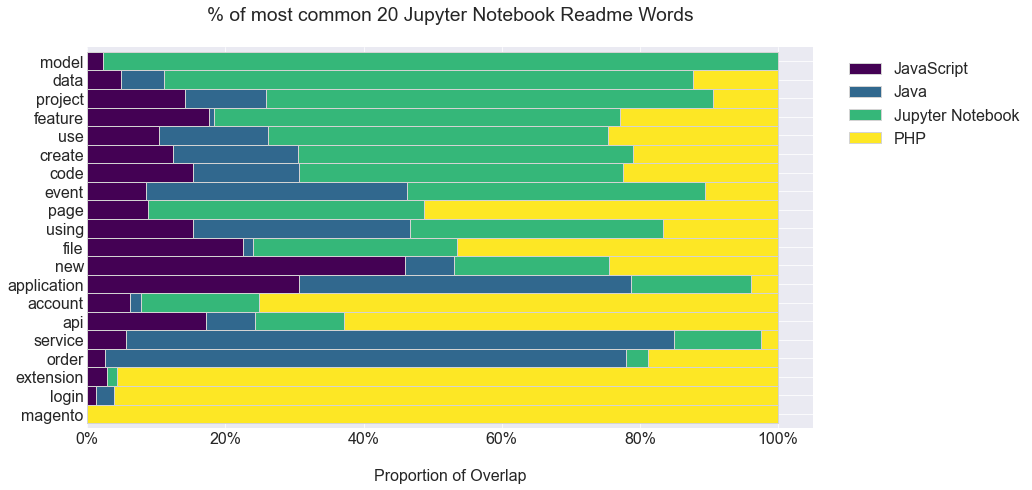

<Figure size 1152x648 with 0 Axes>

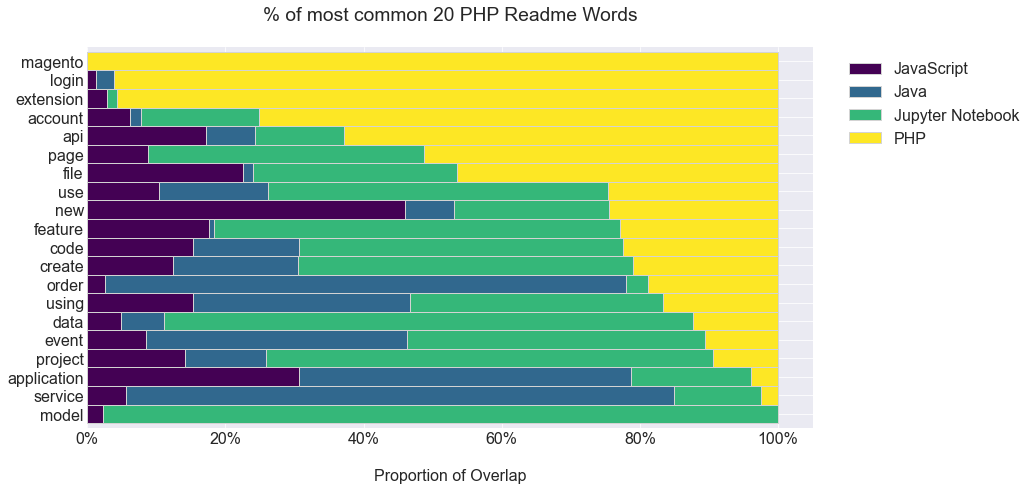

In [13]:
for language in languages:
    ex.plot_overlap_stacked_bar(word_counts, language, cmap = 'viridis')

#### Creating Bigrams and Trigrams

In order to create bigrams and trigrams we need to create lists of all the words in each language category to pass into the NLTK bigram and trigram functions. 

In [14]:
# create words lists
words = ' '.join(train['lemmatized'])
all_words = words.split()

words = ' '.join(train[train.language == 'JavaScript']['lemmatized'])
javascript_words = words.split()

words = ' '.join(train[train.language == 'Java']['lemmatized'])
java_words = words.split()

words = ' '.join(train[train.language == 'PHP']['lemmatized'])
php_words = words.split()

words = ' '.join(train[train.language == 'Jupyter Notebook']['lemmatized'])
jupyter_words = words.split()


all_the_words_list = [javascript_words, java_words, jupyter_words, php_words, all_words]

And here we will use a function that creates a wordcloud and a bar chart from the top number (in this case 20) bigrams.

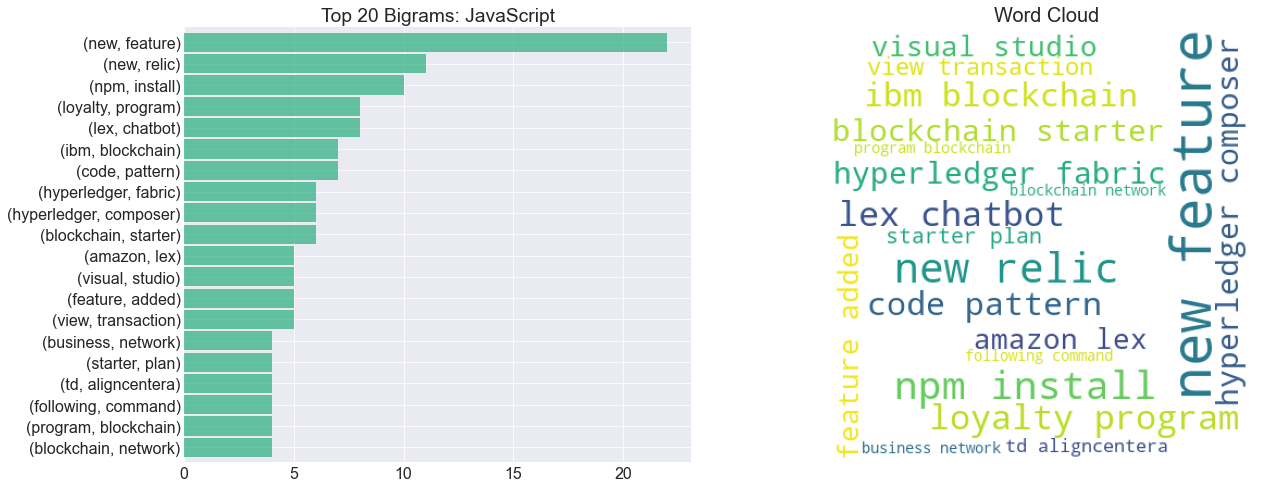

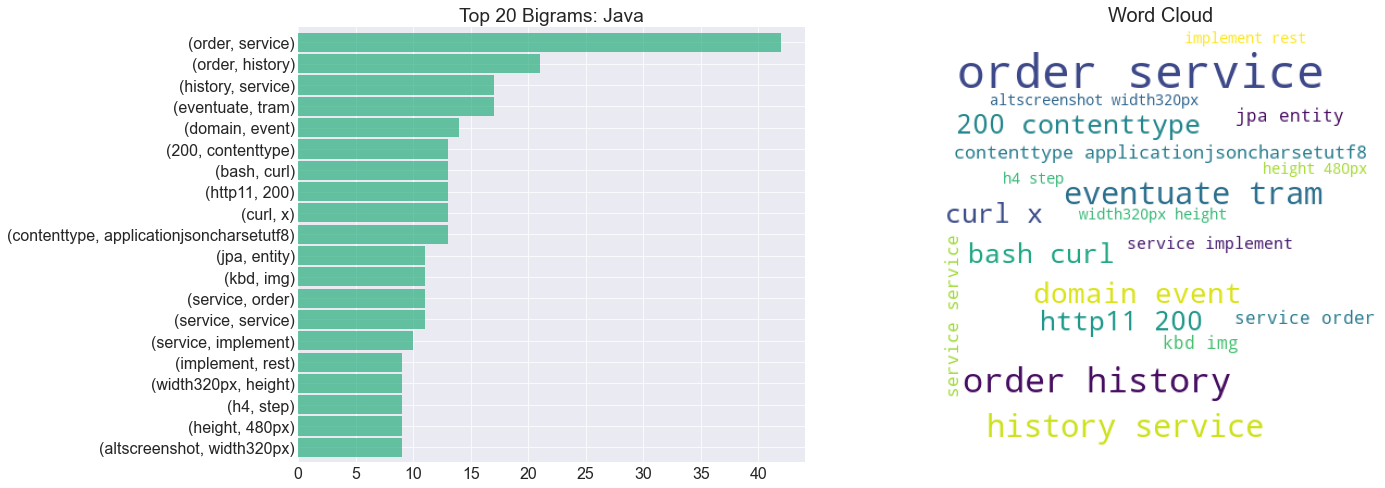

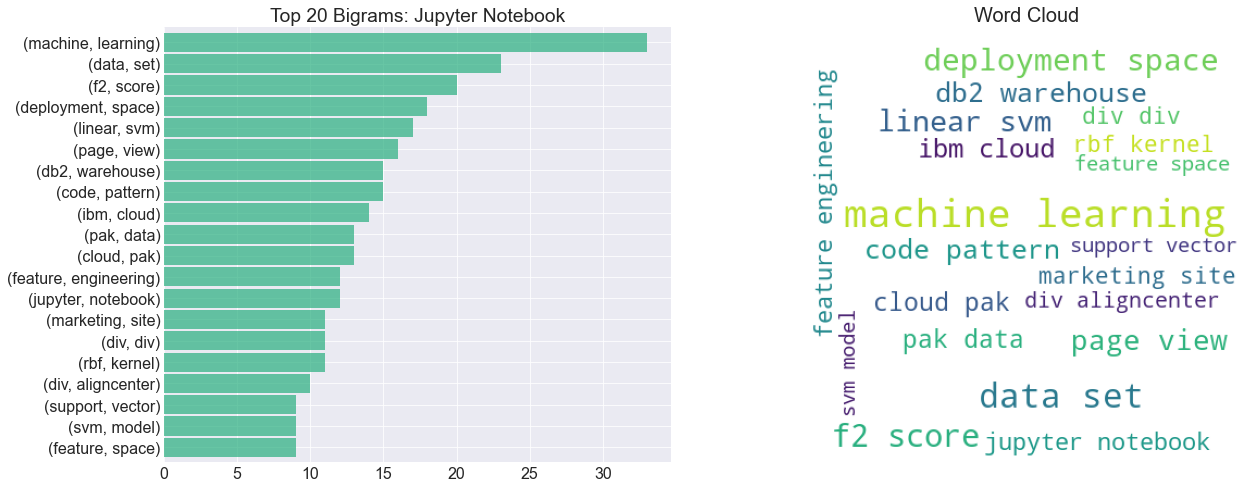

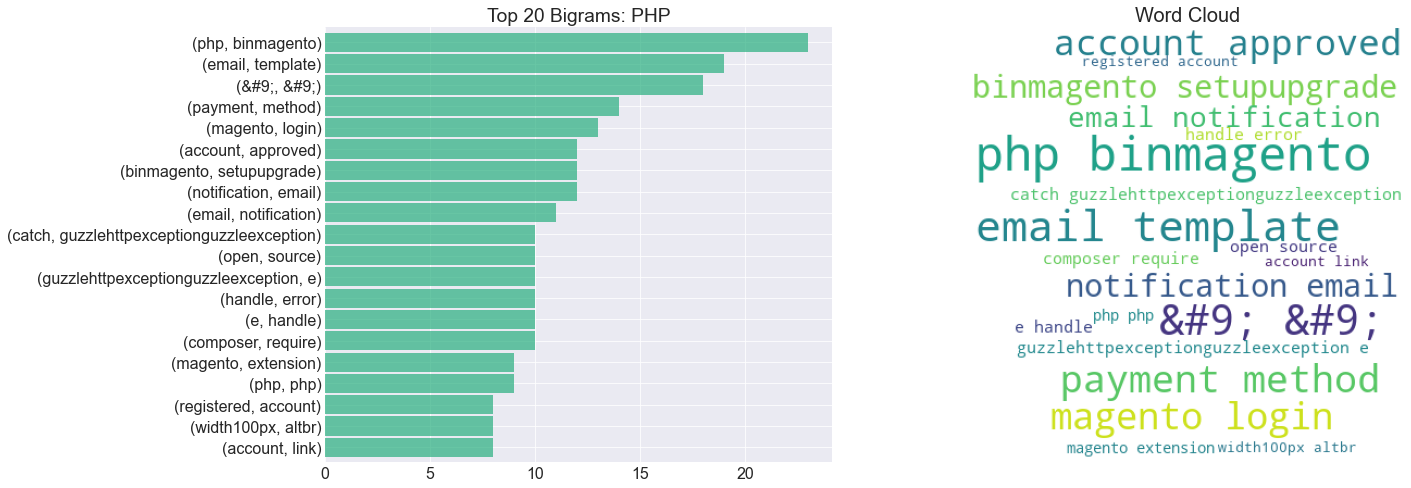

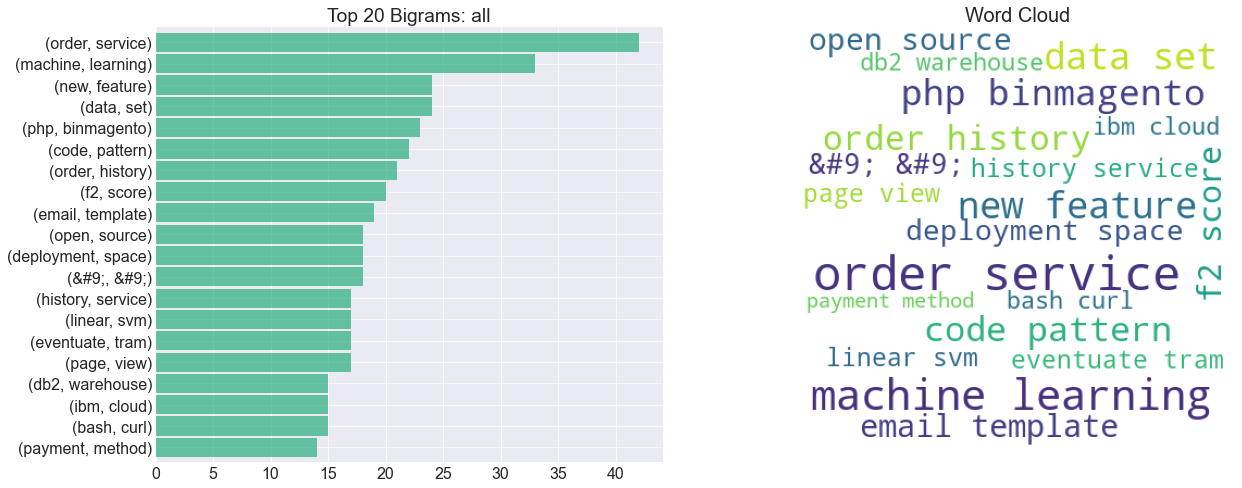

In [15]:
for x, name in zip(all_the_words_list, column_names):
    ex.bigram_count_word_cloud(x, title_name = name)

------
This function does the same as the one above but with trigrams. 

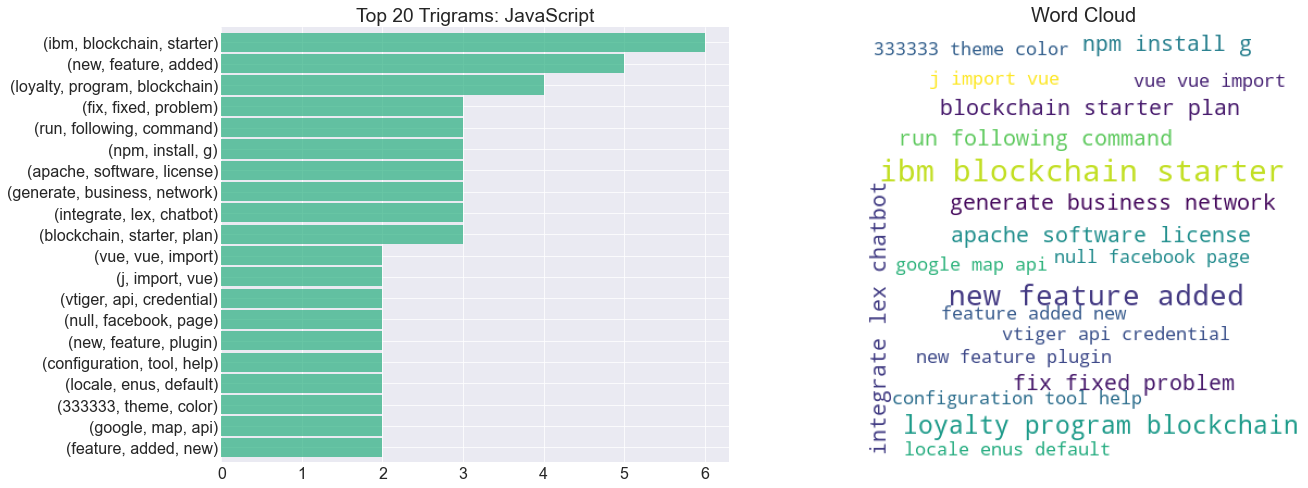

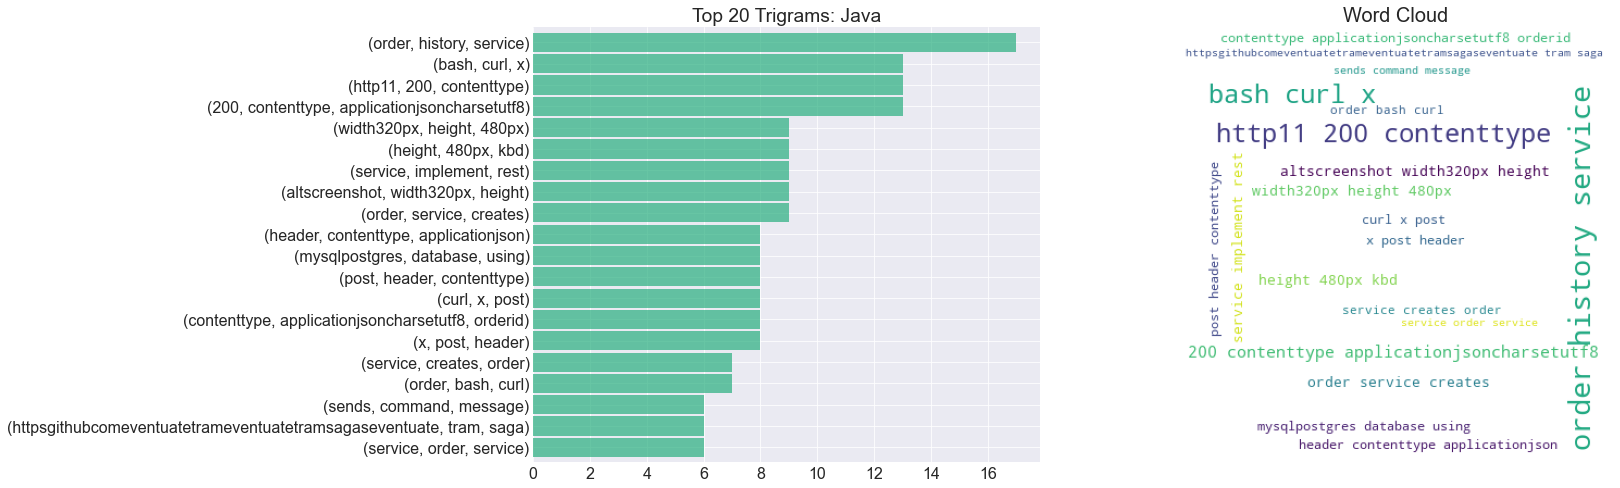

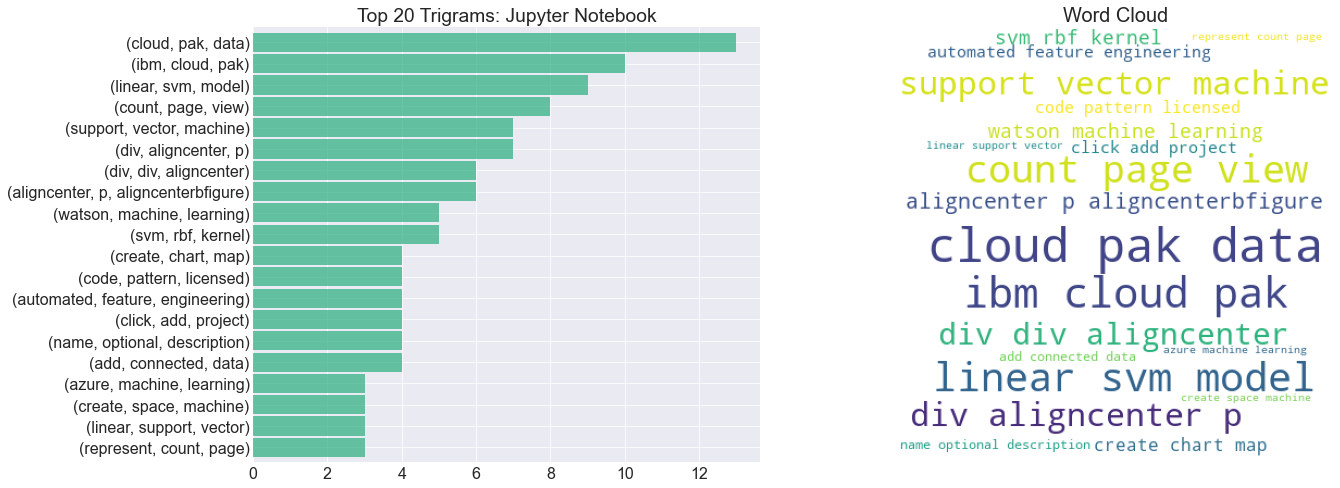

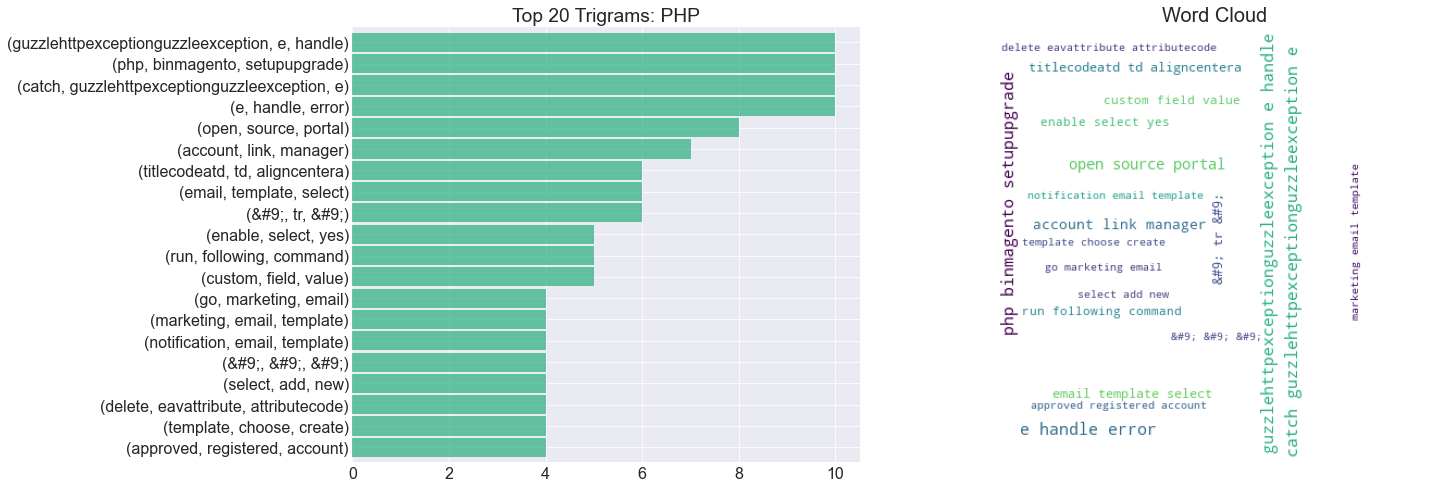

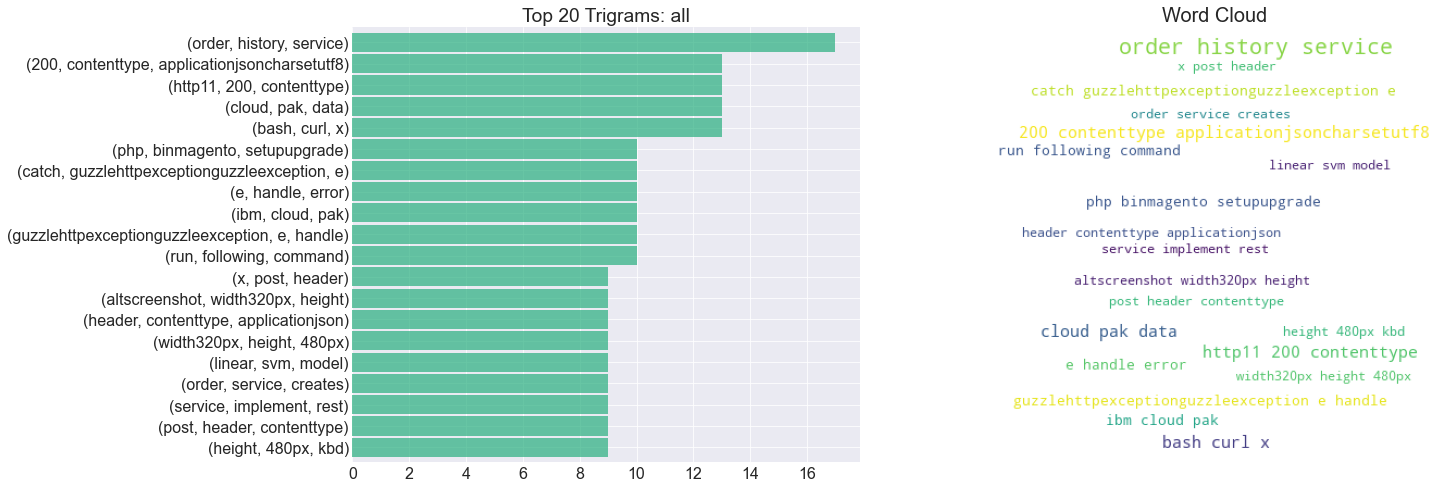

In [16]:
for x, name in zip(all_the_words_list, column_names):
    ex.trigram_count_word_cloud(x, title_name = name)

### Takeaways Bigrams and Trigrams with Lemmatized Words
- There are pretty distinct trigrams and bigrams between the different languages
- Could try modeling with both
- Some ngrams like 'watson assistant service' and 'marketing site' might be there because of the domain, we'll have to pay attention to those words during modeling

## Exploration with Stemmed words
Here we follow the same process but using the stemmed words instead of the lemmatized ones. In this section, because of the way stemming works to reduce each word down to it's root (read more [here](https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/)), the words in this section will appear more fragmented and might not result in actual English words.

We did notice that no matter if we stemmed or lemmatized the data, the common words were very close to the same. These two processes seem to have a similar effect on the data. If we were going to choose one over the other we would take several different things into account. For example, if we needed to process a lot of readmes and needed to do so quickly, we might choose to use stemmed data over lemmatized. And because they have such similar findings in this case, it would most likely be comparable.  

In [17]:
# create separate dfs for the top languages utilizing stemmed data
all_word_counts = ex.get_word_counts_series(train, 'stemmed')
java_word_counts = ex.get_word_counts_series(train[train.language == 'Java'], 'stemmed')
javascript_word_counts = ex.get_word_counts_series(train[train.language == 'JavaScript'], 'stemmed')
php_word_counts = ex.get_word_counts_series(train[train.language == 'PHP'], 'stemmed')
jupyter_word_counts = ex.get_word_counts_series(train[train.language == 'Jupyter Notebook'], 'stemmed')

In [18]:
# create a list of the unique languages from the df
cols = list(df.language.unique())
cols.append('all')
cols

['JavaScript', 'Java', 'Jupyter Notebook', 'PHP', 'all']

In [19]:
# create a list from 
words_counts = [javascript_word_counts, java_word_counts, jupyter_word_counts, php_word_counts, all_word_counts]

# combine the word counts and make them into a dataframe
words_counts = pd.concat(words_counts, axis=1).fillna(0)
# assign column names
words_counts.columns = cols
words_counts.head()

JavaScript  Java  Jupyter Notebook   PHP  all
new           45.0   7.0              22.0  24.0   98
use           42.0  82.0             141.0  74.0  339
instal        35.0   8.0               5.0  45.0   93
run           24.0   7.0              26.0  19.0   76
featur        24.0   1.0              77.0  30.0  132

<Figure size 1152x648 with 0 Axes>

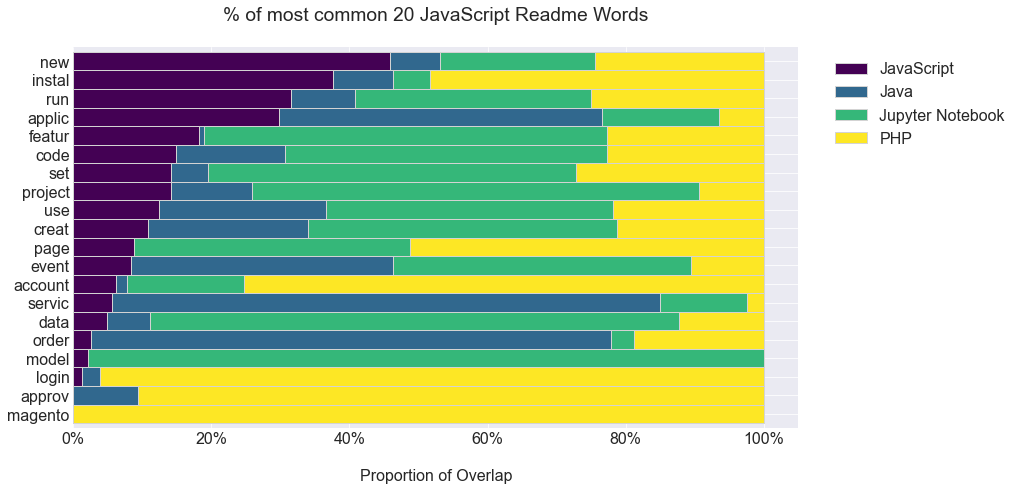

<Figure size 1152x648 with 0 Axes>

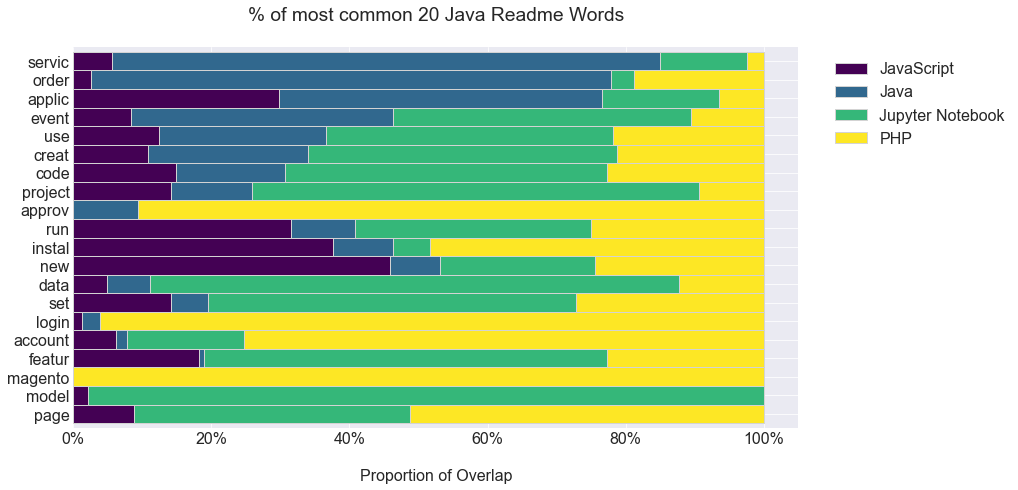

<Figure size 1152x648 with 0 Axes>

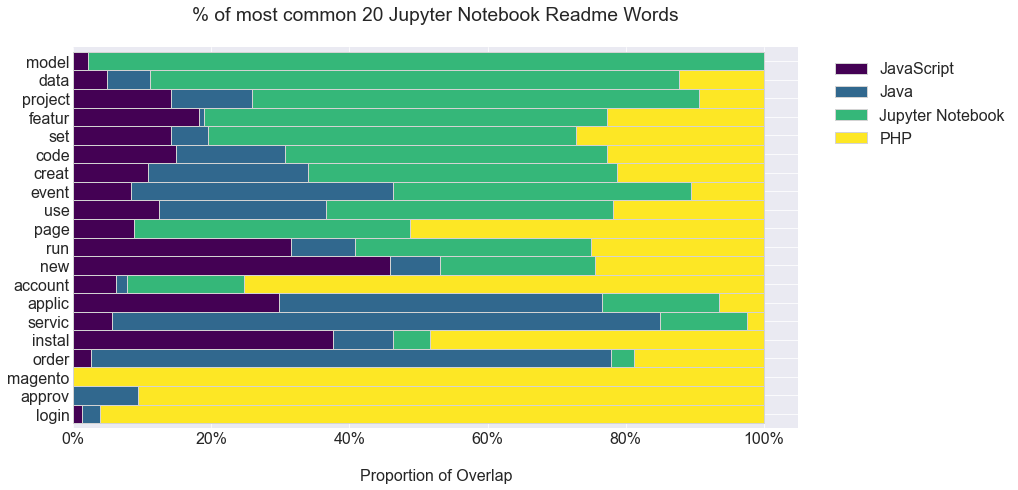

<Figure size 1152x648 with 0 Axes>

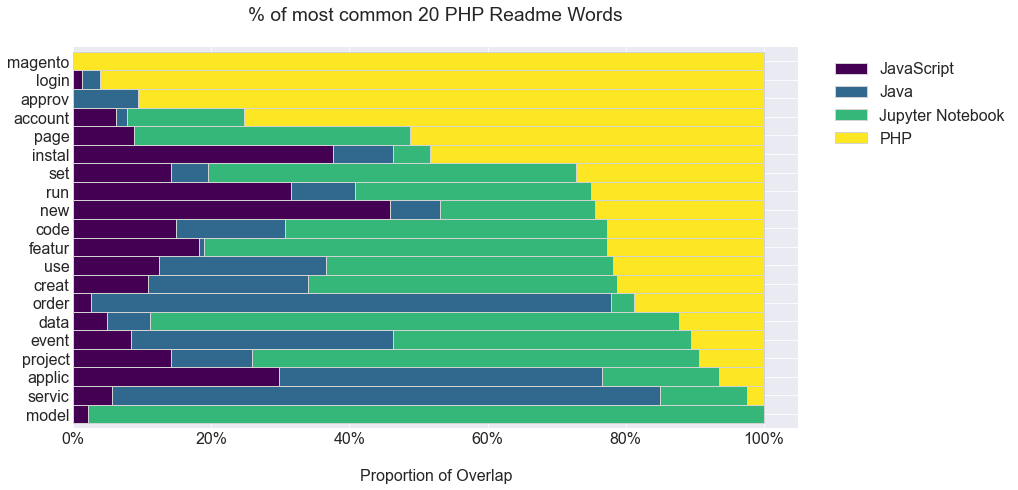

In [20]:
for i in words_counts.drop(columns='all').columns.tolist():
    ex.plot_overlap_stacked_bar(words_counts, i, num_top = 20,cmap = 'viridis');

**Takeaways**


- We can see a commonality in numerous words such as applic, magento and model within the top 20 most words of each language.


- Another thing obvious to note is the obvious cut off of words such as approv, applic and servic. This is a noticeable difference in the stemmed versus lemmatized version.

In [21]:
# create words lists from stemmed data

words = ' '.join(train['stemmed'])
all_words = words.split()

words = ' '.join(train[train.language == 'JavaScript']['stemmed'])
javascript_words = words.split()

words = ' '.join(train[train.language == 'Java']['stemmed'])
java_words = words.split()

words = ' '.join(train[train.language == 'PHP']['stemmed'])
php_words = words.split()

words = ' '.join(train[train.language == 'Jupyter Notebook']['stemmed'])
jupyter_words = words.split()


all_the_words_list = [javascript_words, java_words, jupyter_words, php_words, all_words]

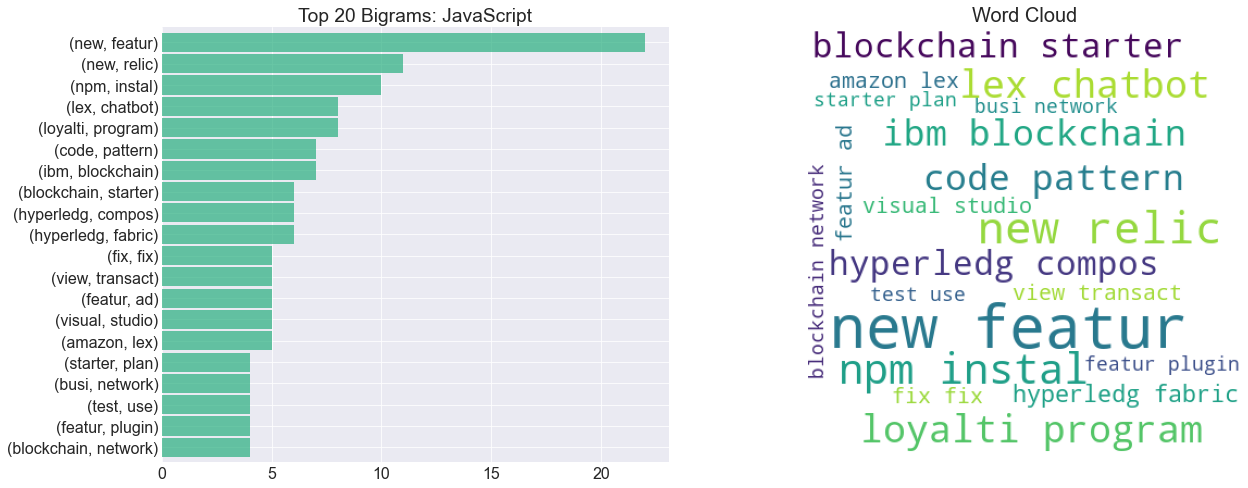

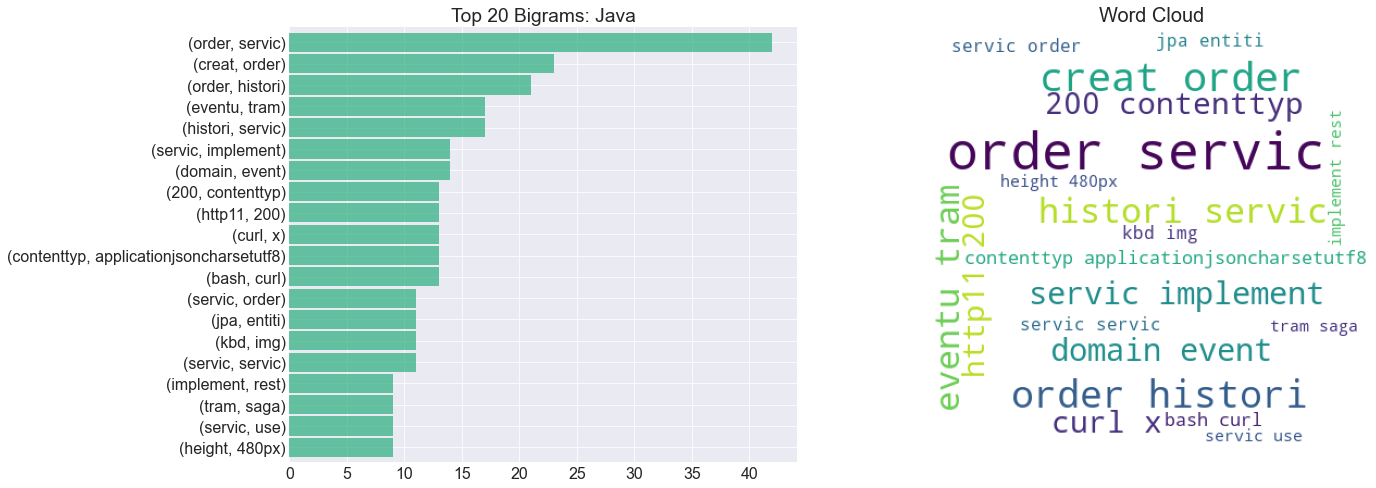

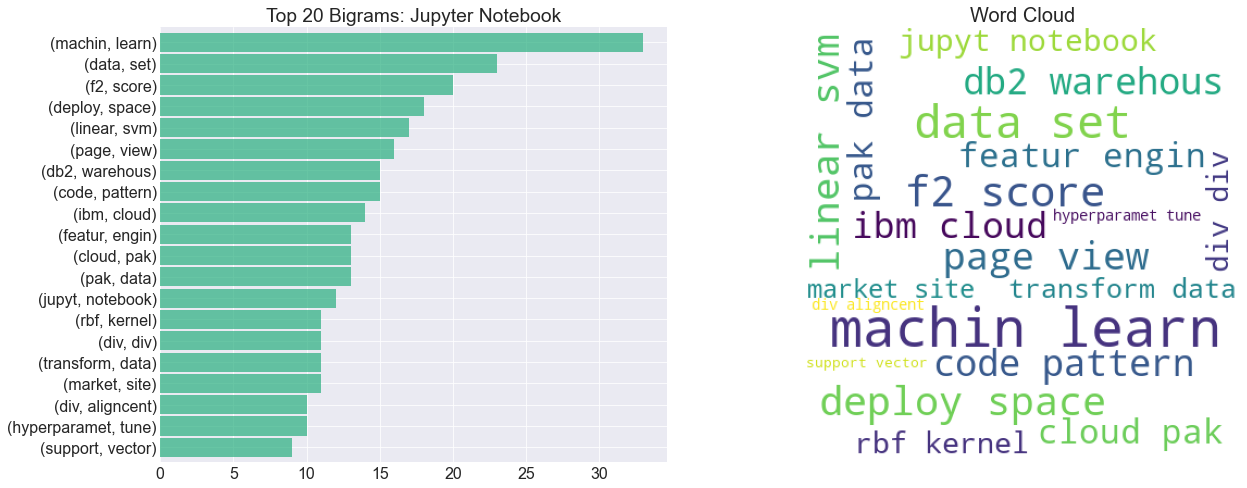

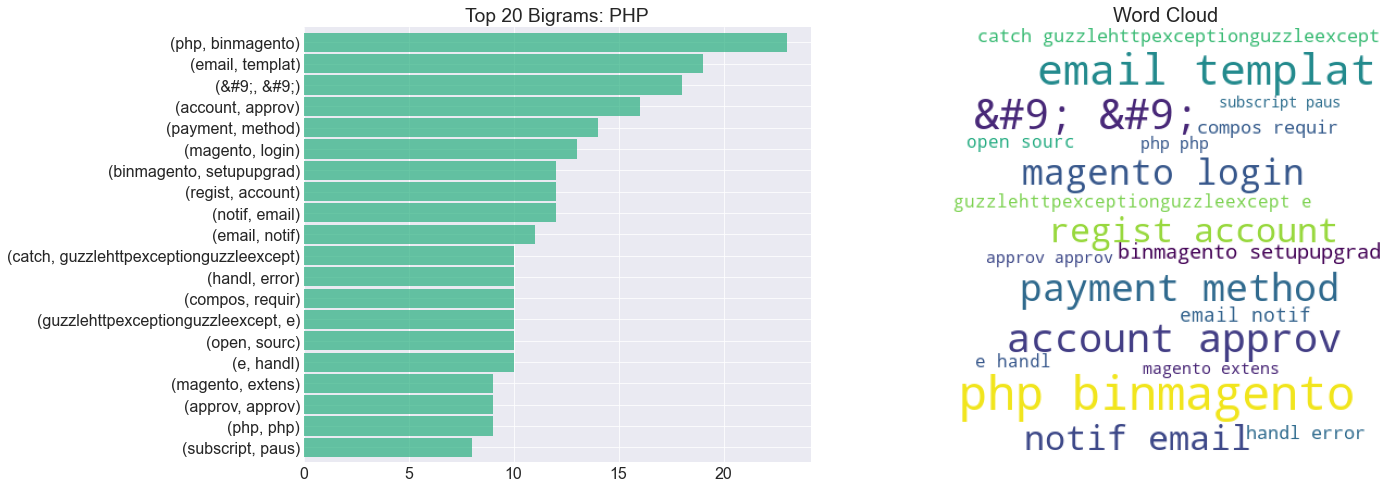

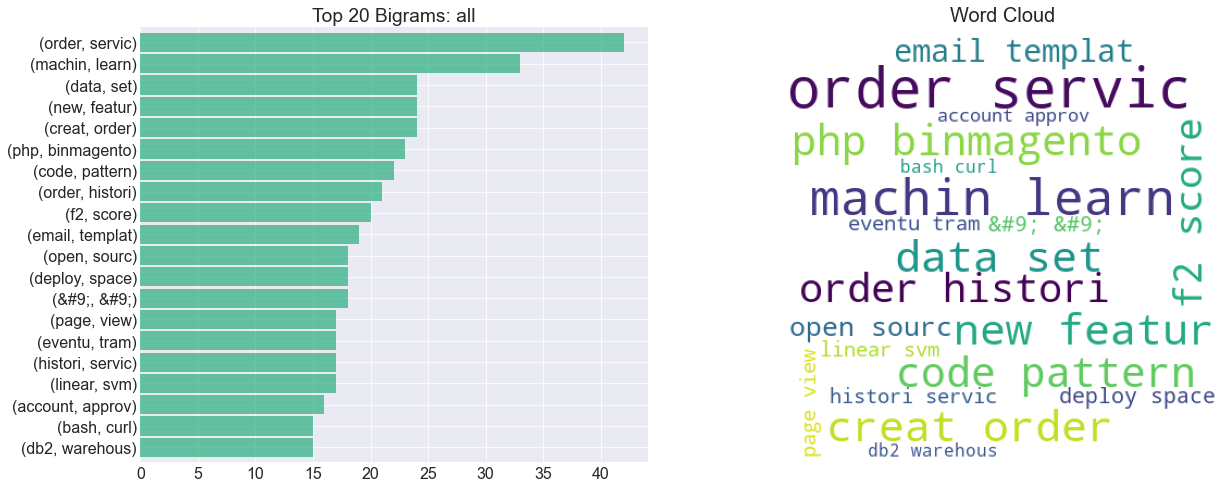

In [22]:
# take a look at the most common bigrams
for x, name in zip(all_the_words_list, cols):
    ex.bigram_count_word_cloud(x, title_name = name)

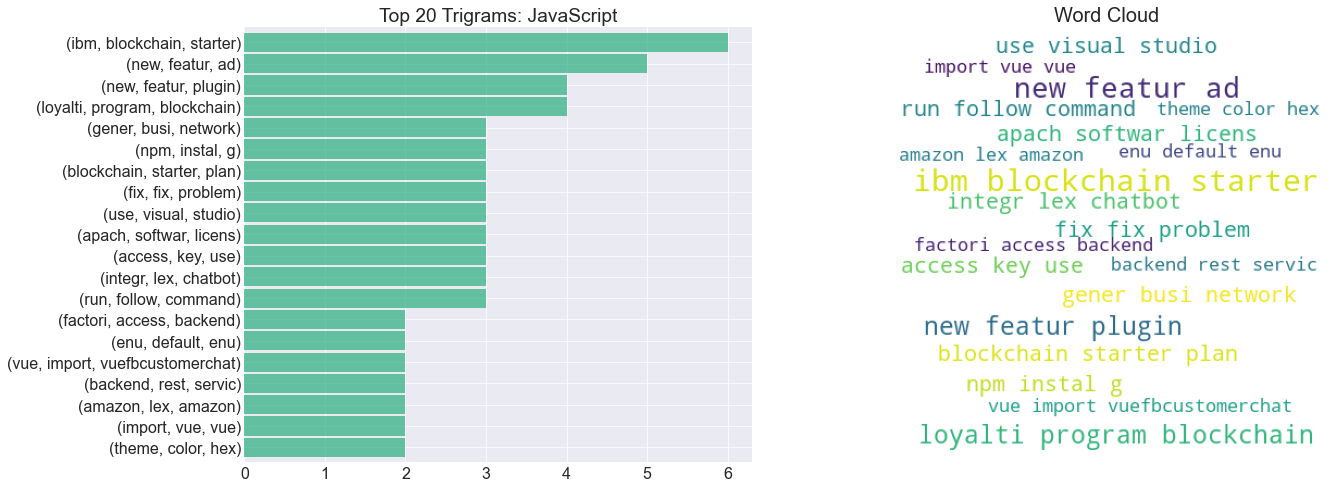

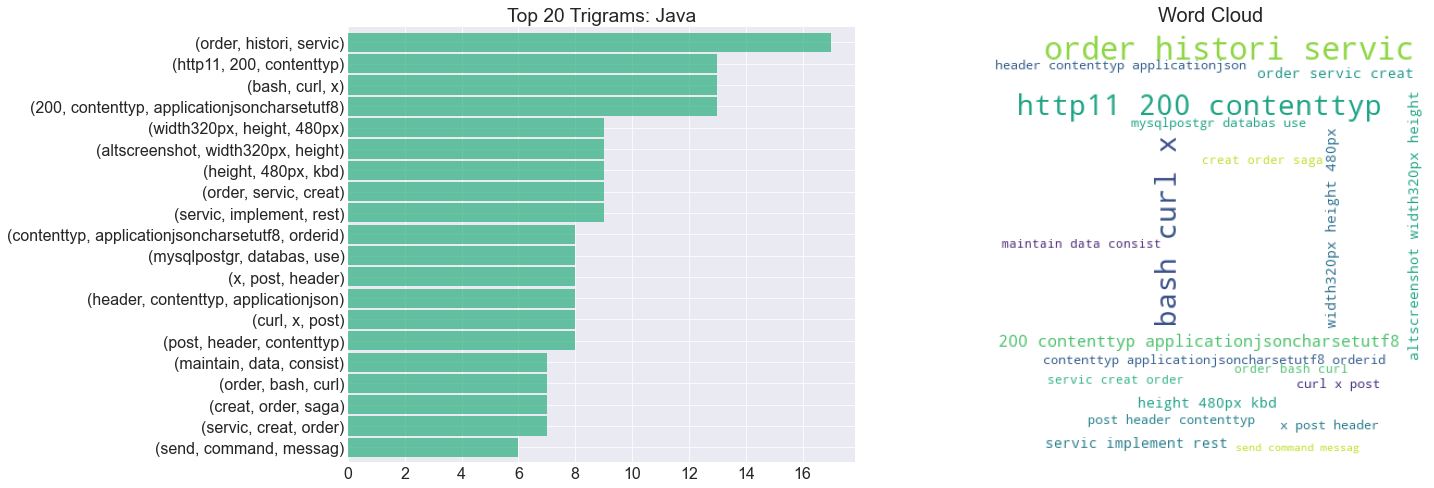

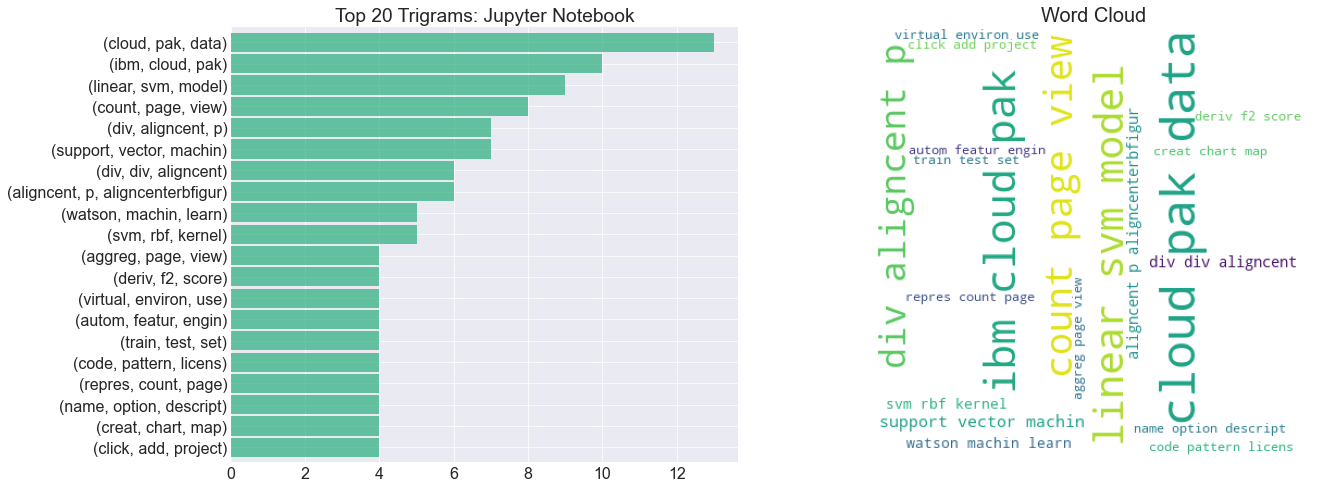

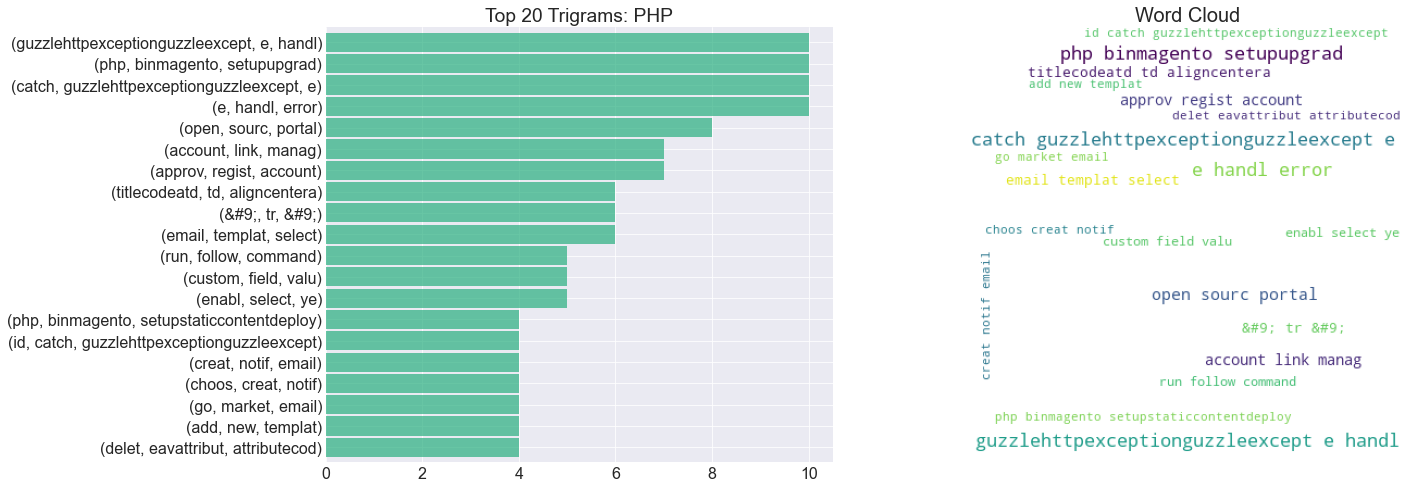

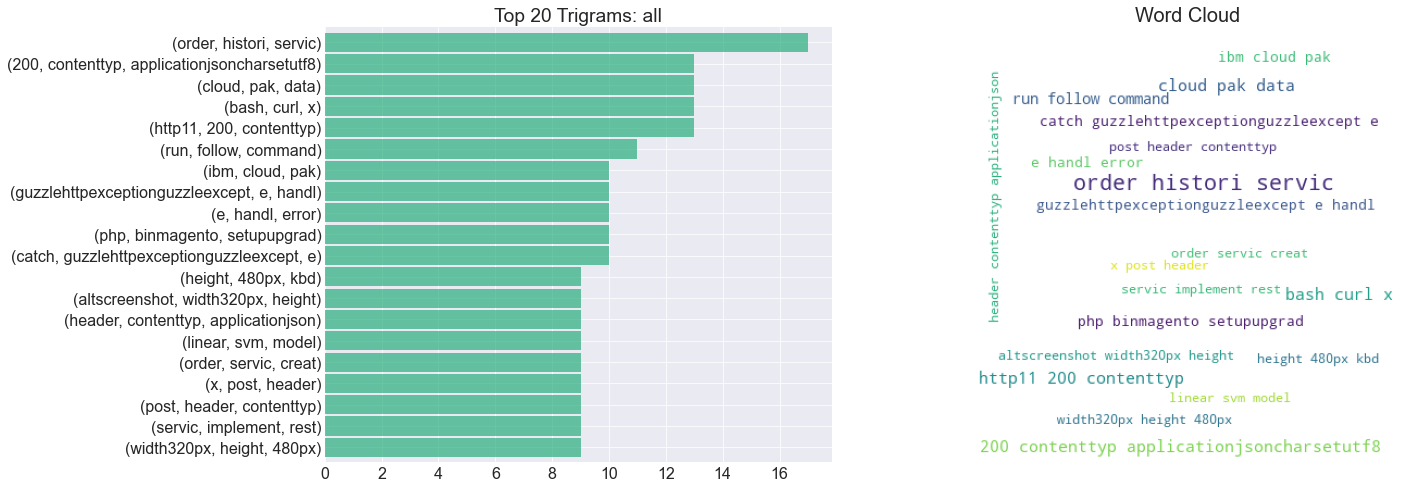

In [23]:
# take a look at the most common trigram for each language
for x, name in zip(all_the_words_list, cols):
    ex.trigram_count_word_cloud(x, title_name = name)

### Takeaways Bigrams and Trigrams with Stemmed Words
- There are no major commonalities across languages between any of the bigrams or trigrams.
- With time we may attempt to create models off both bigrams and trigrams.

------
## Modeling

Because this class is a multi class classification problem we tried several machine learning algorithms for that specific target. 

We found that an SVC (support vector classifier) used on the lemmatized data had the highest accuracy score on the validate set (81%). And a 82% on the test data (the unseen data).

Among the models we tested were: Naiev Bayes, SVC (Support Vector Classification), Decision Tree, Random Forest, KNN, logistic regression. 

We tried the models with stemmed and lemmatized data and without doing either of those. 

### Baseline 
To set up our baseline accuracy, we used the most common method. Since the majority of the readmes we had were PHP, if our model theoretically only guessed PHP every time, this would be the resulting accuracy.

In [24]:
#PHP is the baseline prediction
print(f'Baseline Accuracy: {round(max(train.language.value_counts()) / train.shape[0] *100)}%')

Baseline Accuracy: 38%


------

In [25]:
# reread in data to make sure no issues with data
df = pd.read_json('data2.json')
df = p.drop_unneeded_data(df)


df = p.prepare_nlp_data(df, content = 'readme_contents', extra_words=['customer', 'customers', '1', '2'])

We're going to go through several different iterations of modeling using a combination of different vectorizers with stemmed, lemmatized or cleaned data. Here we set up a dataframe to view the scores, and we'll take a look at that at the end

In [26]:
# create dataframe to store the scores
score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])

We're trying first using a TD/IDF vectorizer on the lemmatized data.

In [27]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

# split to X/y datasets 
X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [28]:
# create list of models to loop through
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression()]

# create list of model names that correspond to models
model_names = ['Naive_Bayes_tfidf_lemmatized', 'SVC_tfidf_lemmatized', 'Decision_tree_tfidf_lemmatized', 
               'Random_forest_tfidf_lemmatized', 'KNN_tfidf_lemmatized', 'Log_reg_tfidf_lemmatized']

# initialize list of names of the languages
class_names = ['Java', 'JavaScript', 'Jupyter Notebook','PHP' ]

In [29]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

We model next with stemmed data still using the TD/IDF vectorizer.

In [30]:
# bring in the vectorizer
tfidf = TfidfVectorizer()

X_data = tfidf.fit_transform(df.stemmed)
y_data = df.language

# split to X/y datasets 
X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [31]:
# make a list of algorithms we want to try for our models
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(), LogisticRegression()]

# name the models
model_names = ['Naive_Bayes_stemmed', 'SVC_stemmed', 'Decision_tree_stemmed', 'Random_forest_stemmed', 'KNN_bigrams_stemmed', 'Log_reg_stemmed']

# list the languages
class_names = ['Java', 'JavaScript', 'Jupyter Notebook','PHP' ]

In [32]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [33]:
score_df

model_name  train_score  validate_score
0     Naive_Bayes_tfidf_lemmatized     0.879310        0.615385
1             SVC_tfidf_lemmatized     1.000000        0.846154
2   Decision_tree_tfidf_lemmatized     1.000000        0.653846
3   Random_forest_tfidf_lemmatized     1.000000        0.653846
4             KNN_tfidf_lemmatized     0.896552        0.807692
5         Log_reg_tfidf_lemmatized     0.948276        0.730769
6              Naive_Bayes_stemmed     0.879310        0.615385
7                      SVC_stemmed     1.000000        0.807692
8            Decision_tree_stemmed     1.000000        0.692308
9            Random_forest_stemmed     1.000000        0.769231
10             KNN_bigrams_stemmed     0.879310        0.769231
11                 Log_reg_stemmed     0.948276        0.730769

**Takeaways**
- Overall most of the models performed well but there is a drop off on the validate data
- It looks like most of the models utilizing the stemmed data are overfit
- Using the stemmed data does not give us better accuracy than the lemmatized data

Let's see how our models do with bigrams using lemmatized data. 

In [34]:
tfidf = TfidfVectorizer(ngram_range=(2,2))
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [35]:
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier()]

model_names = ['Naive_Bayes_tfidf2', 'SVC_tfidf2', 'Decision_tree_tfidf2', 'Random_forest_tfidf2', 'KNN_bigrams_tfidf2']

class_names = ['Java', 'JavaScript', 'Jupyter Notebook','PHP' ]

In [36]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

And now using just the clean data (not lemmatized or stemmed)

In [37]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.clean)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

In [38]:
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(), KNeighborsClassifier(n_neighbors=10, weights= 'distance'),
             LogisticRegression()]

model_names = ['Naive_Bayes_tfidf_clean', 'SVC_tfidf_clean', 'Decision_tree_tfidf_clean', 'Random_forest_tfidf_clean', 'KNN_n10_tfidf_clean',
              'Log_reg_clean']

class_names = ['Java', 'JavaScript', 'Jupyter Notebook','PHP' ]

In [39]:
for model, name in zip(model_list, model_names):
    score_df = m.test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [40]:
score_df.sort_values(by = 'validate_score', ascending = False)

model_name  train_score  validate_score
18                 SVC_tfidf_clean     1.000000        0.846154
1             SVC_tfidf_lemmatized     1.000000        0.846154
21             KNN_n10_tfidf_clean     1.000000        0.807692
4             KNN_tfidf_lemmatized     0.896552        0.807692
16              KNN_bigrams_tfidf2     0.862069        0.807692
7                      SVC_stemmed     1.000000        0.807692
10             KNN_bigrams_stemmed     0.879310        0.769231
20       Random_forest_tfidf_clean     1.000000        0.769231
9            Random_forest_stemmed     1.000000        0.769231
11                 Log_reg_stemmed     0.948276        0.730769
22                   Log_reg_clean     0.948276        0.730769
5         Log_reg_tfidf_lemmatized     0.948276        0.730769
8            Decision_tree_stemmed     1.000000        0.692308
19       Decision_tree_tfidf_clean     1.000000        0.692308
3   Random_forest_tfidf_lemmatized     1.000000        0.653846
2   Decision_tree_tfidf_lemmatized     1.000000        0.653846
13                      SVC_tfidf2     0.982759        0.615385
6              Naive_Bayes_stemmed     0.879310        0.615385
17         Naive_Bayes_tfidf_clean     0.879310        0.615385
0     Naive_Bayes_tfidf_lemmatized     0.879310        0.615385
14            Decision_tree_tfidf2     1.000000        0.576923
12              Naive_Bayes_tfidf2     0.965517        0.423077
15            Random_forest_tfidf2     1.000000        0.384615

#### The top score is the Support Vector Classifier using the lemmatized data utilizing the TD/IDf method. Let's take a deeper look at the results from that model with the Train and Validate datasets.

                   ============== SVC ================           
LinearSVC()
~~~~~~~~Train Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         8
      JavaScript       1.00      1.00      1.00        11
Jupyter Notebook       1.00      1.00      1.00        17
             PHP       1.00      1.00      1.00        22

        accuracy                           1.00        58
       macro avg       1.00      1.00      1.00        58
    weighted avg       1.00      1.00      1.00        58



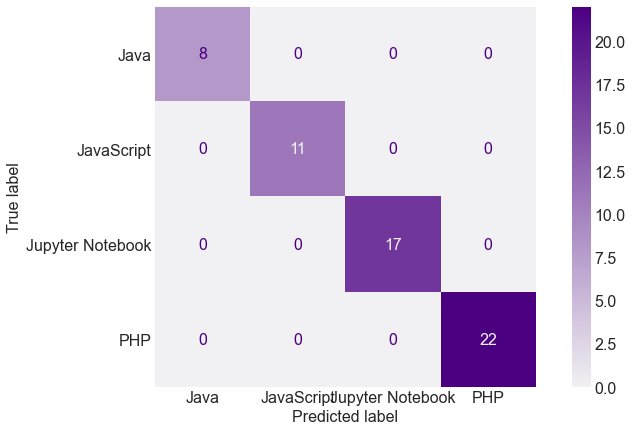


LinearSVC()
~~~~~~~~Validate Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      0.25      0.40         4
      JavaScript       1.00      0.80      0.89         5
Jupyter Notebook       0.78      1.00      0.88         7
             PHP       0.83      1.00      0.91        10

        accuracy                           0.85        26
       macro avg       0.90      0.76      0.77        26
    weighted avg       0.88      0.85      0.82        26



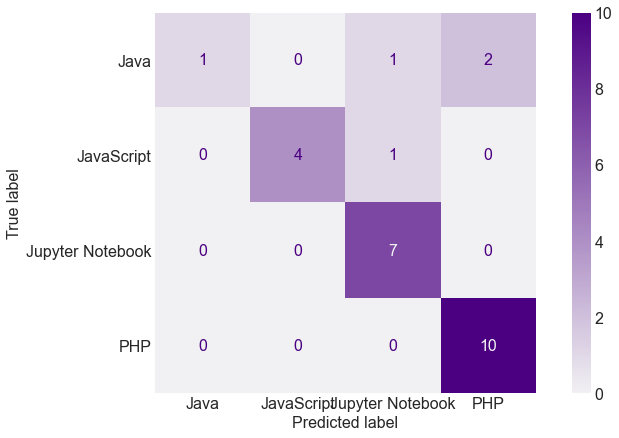


-------------------------------------------------------------------



In [41]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

m.make_models_and_print_metrics(LinearSVC(), 'SVC', X_train, y_train, X_validate, y_validate, class_names)

### Takeaways
While the model is overfit on the training data, it seems to still do well on the Validate set (85% accuracy). It might be due to the amount of readmes we are pulling from. Keep in mind, we have a lot less Java and Javascript readmes. If we pulled data from some more Java and Javascript readmes, we might be able to improve on this. We can take this model now to our test data to see how it performs. 

### Testing on the unseen data

In [42]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.lemmatized)
y_data = df.language

X_train, y_train, X_validate, y_validate, X_test, y_test = m.nlp_X_train_split(X_data, y_data)

                   ============== SVC ================           
LinearSVC()
~~~~~~~~Test Scores~~~~~~~~~
                  precision    recall  f1-score   support

            Java       1.00      0.33      0.50         3
      JavaScript       1.00      0.60      0.75         5
Jupyter Notebook       0.86      1.00      0.92         6
             PHP       0.73      1.00      0.84         8

        accuracy                           0.82        22
       macro avg       0.90      0.73      0.75        22
    weighted avg       0.86      0.82      0.80        22



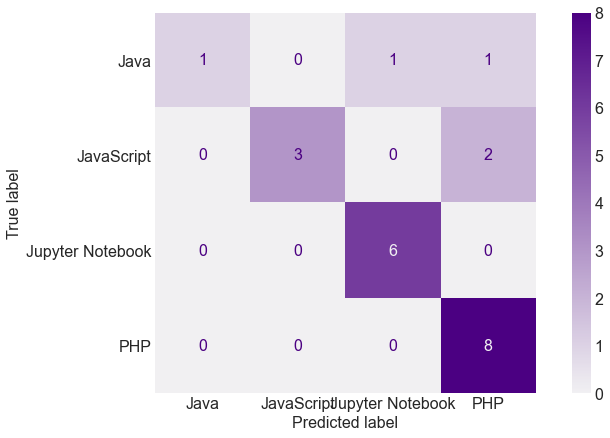


-------------------------------------------------------------------



In [43]:
# The second confusion matrix should be test
# maybe create new function for this 
m.make_models_and_print_metrics_test_data(LinearSVC(), 'SVC', X_train, y_train, X_test, y_test, class_names)

#### How do the models stack up against each other?

In [44]:
# set palette
sns.set_palette('viridis_r')

# set up second dataframe for scores top 7 
score_df2 = score_df.set_index('model_name').sort_values(by = ['validate_score', 'model_name'], ascending = False).head(7)

# add the test score to the model we tested on (SVC)
score_df2['test_score']= [0.82, 0, 0, 0, 0, 0, 0]

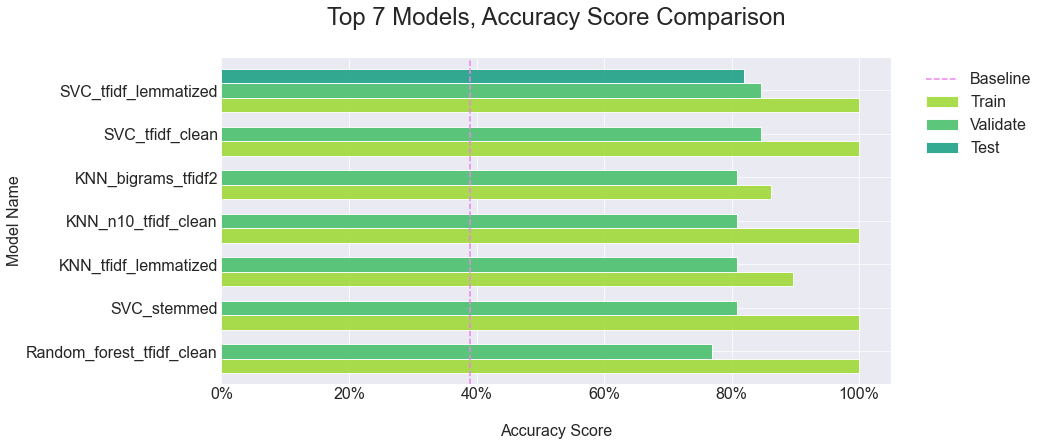

In [45]:
score_df2.sort_values(by= ['test_score', 'validate_score']).plot.barh(alpha = .9, width = 1, ec = 'white', 
                                                                      figsize = (12,6))
# plot baseline
plt.axvline(x = .39, c = 'violet', linestyle = '--')
plt.legend(['Baseline','Train', 'Validate','Test'], bbox_to_anchor = (1.03,1))
plt.ylabel('Model Name')
plt.xlabel('\nAccuracy Score')
# set ticks to percentages
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))
plt.title('Top 7 Models, Accuracy Score Comparison\n', fontsize = 24)
plt.show()

## Conclusion
With an accuracy of 82% the SVC model on lemmatized data, using a TD/IDF Vectorizer, performed quite well. Notice that it is not accurate when it comes to predicting Java repos, but we saw similar performance on the validate set. It is not surprising that it classifies 2 of the JavaScript readmes as PHP as those two languages are commonly used together in projects. We might be able to remedy this problem, by giving the model more data from Java and JavaScript readmes to work with. In the test dataset there were only 3 Java Readmes, and 5 javascript Readmes. 

### With More Time...
We would love to acquire more data to work with, especially for Java and JavaScript readmes, in hopes that this would give our model a bit more to work with. Also we'd love to change the languages we are aiming for, to see if this SVC model still performs well even with different target languages. 